In [99]:
import sys
import os
os.listdir("..")

['vgg.py',
 'store.png',
 'in.png',
 'out.png',
 'content.png',
 '__pycache__',
 'inspo',
 '.gitignore',
 'scripts',
 'comprehending.ipynb',
 'losses.py',
 '.ipynb_checkpoints',
 '.git',
 'style.png']

In [100]:
sys.path.append('..')
from losses import *
from vgg import VGG

In [101]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
def display_image(tensor):
    plt.imshow(tensor.squeeze().permute(1, 2, 0)  )

def size_to_fit(size, max_dim, scale_up=False):
    w, h = size
    if not scale_up and max(h, w) <= max_dim:
        return w, h
    new_w, new_h = max_dim, max_dim
    if h > w:
        new_w = round(max_dim * w / h)
    else:
        new_h = round(max_dim * h / w)
    return new_w, new_h


# Function to load and preprocess the image
def load_image(url, size=224):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Transformation: Resize and center crop
    transform = transforms.Compose([
        transforms.Resize(size),  # Resize so the smaller side is size
        transforms.CenterCrop(size),  # Center crop to the desired size
        transforms.ToTensor(),  # Convert the PIL Image to a tensor
    ])

    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image


# Instantiate the VGG class (for example, extracting features from layers 3, 8, 17, and 26)


In [102]:
content_url = "https://static1.smartbear.co/smartbearbrand/media/images/home/sb-hero-bg-img.jpg"
content_image = load_image(content_url)
display_image(content_image)

In [103]:
content_image.shape

torch.Size([1, 3, 224, 224])

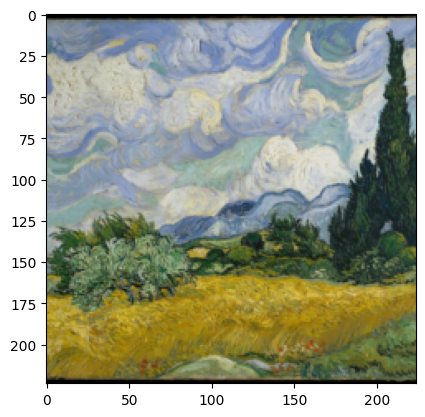

In [104]:
style_url = "https://collectionapi.metmuseum.org/api/collection/v1/iiif/436535/796067/main-image"
style_image = load_image(style_url)
display_image(style_image)

Getting the optimization targets

In [105]:
content_layers = [22]
content_weights = [350] 

style_layers = [1, 6, 11, 20, 29]
style_weights = [256, 64, 16, 4, 1]
layers = style_layers + content_layers

vgg = VGG(layers=style_layers + content_layers)


style_features = vgg(style_image, style_layers)
style_targets = []
for i in style_features.keys():
    style_targets.append(GramMatrix()(style_features[i]).detach())

content_features = vgg(content_image, content_layers)
content_targets = []
for i in content_features.keys():
    content_targets.append(content_features[i].detach())


In [106]:
style_targets[0].shape

torch.Size([1, 64, 64])

In [107]:
content_targets[0].shape

torch.Size([1, 512, 28, 28])

In [110]:
class StyleLoss(nn.Module):
    # Register target gram matrix for reuse
    def __init__(self, target_gram):
        super().__init__()
        self.register_buffer('target', target_gram)

    # Forward pass- Gram Matrix distance
    def forward(self, input):
        return nn.MSELoss()(GramMatrix()(input), self.target)

temp = StyleLoss(style_targets[0])

In [111]:
temp.target

tensor([[[1.1804e-01, 6.0024e-01, 0.0000e+00,  ..., 0.0000e+00,
          4.8101e-01, 8.0435e-01],
         [6.0024e-01, 1.1643e+02, 0.0000e+00,  ..., 1.4034e+00,
          6.8504e+01, 1.1498e+02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 1.4034e+00, 0.0000e+00,  ..., 5.7642e-01,
          1.5742e+00, 2.1822e+00],
         [4.8101e-01, 6.8504e+01, 0.0000e+00,  ..., 1.5742e+00,
          7.2192e+01, 9.1031e+01],
         [8.0435e-01, 1.1498e+02, 0.0000e+00,  ..., 2.1822e+00,
          9.1031e+01, 1.5903e+02]]])

In [159]:
[type(f) for f in loss_fns]

[__main__.StyleLoss,
 __main__.StyleLoss,
 __main__.StyleLoss,
 __main__.StyleLoss,
 __main__.StyleLoss,
 losses.ContentLoss]

In [112]:
loss_fns = []
for style_target in style_targets:
    loss_fns.append(StyleLoss(style_target))
for content_target in content_targets:
    loss_fns.append(ContentLoss(content_target))


In [165]:
display_image(output_image.clone().detach())

In [167]:
from tqdm import tqdm
output_image = content_image.detach().clone()
output_image.requires_grad_(True)

from torch import optim
losses = []
images = []
opt = optim.Adam([output_image], lr=5/255)
for i in tqdm(range(500)):
#     print(i)
    if (i%100==0):
        images.append(output_image.clone().detach())
#         display_image(output_image.clone().detach()
    features = vgg(output_image)

    loss = torch.tensor(0., requires_grad=True)

    x = 0
    for i in style_layers:
        current_features = GramMatrix()(features[i])
        style_lossnow = loss_fns[x](current_features)
        loss = loss +style_lossnow
        x += 1

    for i in content_layers:
        current_features = features[i]
        content_lossnow = loss_fns[x](current_features)
        loss = loss +content_lossnow
        x += 1
        
    opt.zero_grad()
    losses.append(loss.item())

    loss.backward()

    opt.step()
    with torch.no_grad():
        output_image.clamp_(0, 1)


 80%|████████████████████████████████▉        | 401/500 [01:59<00:29,  3.36it/s]


KeyboardInterrupt: 

In [154]:
copied_image = output_image.detach().clone()
# display_image(output_image)


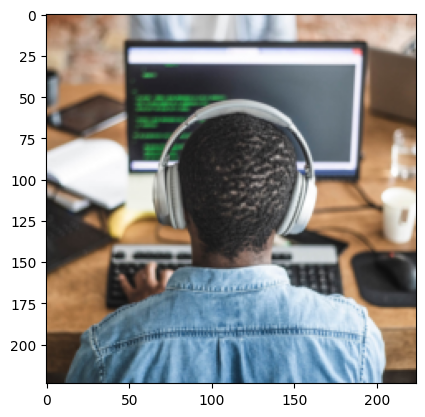

In [168]:
display_image(images[0])

In [169]:
display_image(images[1])

In [170]:
display_image(images[2])

In [171]:
display_image(images[3])

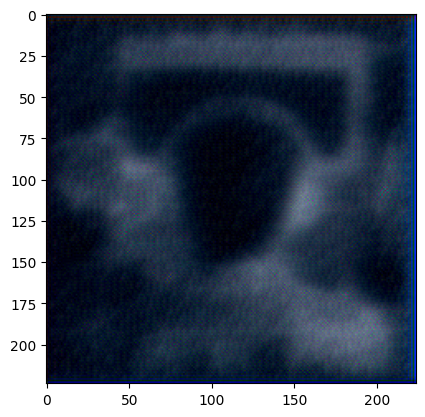

In [172]:
display_image(images[4])

In [158]:
loss.shape

torch.Size([])

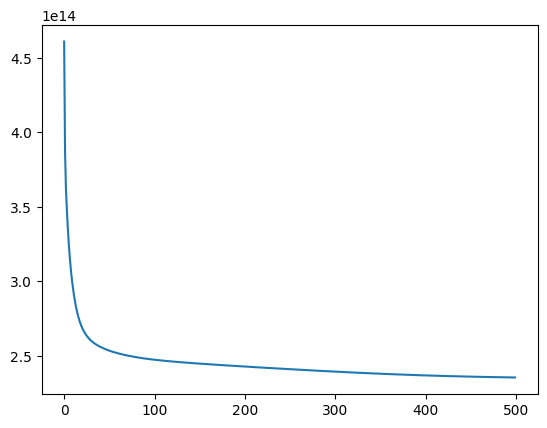

In [157]:
cop = [l.detach().clone() for l in losses]
plt.plot(cop)

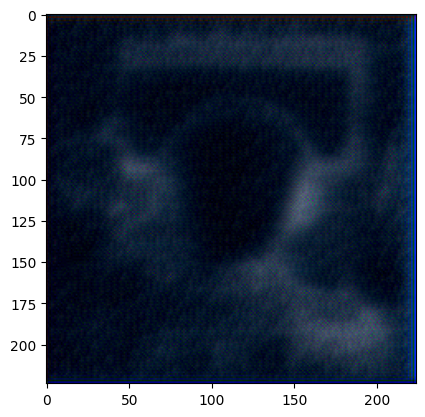

In [155]:
display_image(copied_image)

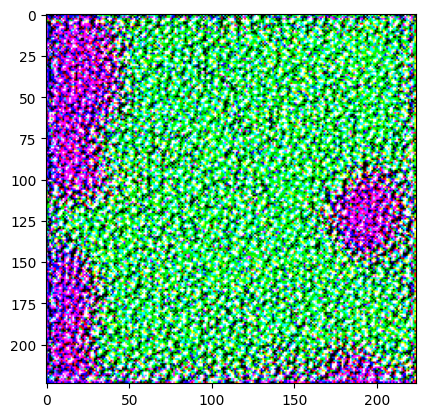

In [152]:
# Image from first iteration- forgot to zero out gradients on the loss
display_image(copied_image)

In [140]:
output_image.grad.reshape(1,-1)[0][:4]

tensor([ 0.0095,  0.0249, -0.0016,  0.0309])

In [129]:
loss = 0

x = 0
for i in style_layers:
    current_features = features[i]

    x += 1

for i in content_layers:
    current_features = features[i]
    x += 1

#     loss += loss_fns[i](current_features)
#     prin()
#     print(current_features.shape)
    
    
# for loss_fn in loss_fns:

#     loss += loss_fn(features)

In [122]:
loss.backward()

AttributeError: 'int' object has no attribute 'backward'

In [123]:
# output_image.grad.shape